In [57]:
import os
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)

In [90]:
data_dir= './dataset'
print(os.listdir(data_dir))
train_class = os.listdir(data_dir+"/train")
valid_class = os.listdir(data_dir+"/validation")
print(f'Training Classes - {train_class}')

print(f'validation Classes - {valid_class}')
Angry=int(len(os.listdir(data_dir+"/train/Angry")))
Disgust=int(len(os.listdir(data_dir+"/train/Disgust")))
Fear=int(len(os.listdir(data_dir+"/train/Fear")))
Happy=int(len(os.listdir(data_dir+"/train/Happy")))
Neutral=int(len(os.listdir(data_dir+"/train/Neutral")))
Sad=int(len(os.listdir(data_dir+"/train/Sad")))
Surprise=int(len(os.listdir(data_dir+"/train/Surprise")))

['fer2013.csv', 'validation', 'README', 'train', 'fer2013.bib']
Training Classes - ['Surprise', 'Angry', 'Happy', 'Sad', 'Disgust', 'Fear', 'Neutral']
validation Classes - ['Surprise', 'Angry', 'Happy', 'Sad', 'Disgust', 'Fear', 'Neutral']


In [91]:
# Data transforms (gray scaling and data augmentation)

training = tt.Compose([tt.Grayscale(num_output_channels=1),
                      tt.RandomHorizontalFlip(),
                      tt.RandomRotation(40),
                      tt.ToTensor()])

validation = tt.Compose([tt.Grayscale(num_output_channels=1),
                      tt.ToTensor()])


In [92]:
train_ds = ImageFolder(data_dir+ '/train', training)
valid_ds = ImageFolder(data_dir+ '/validation', validation)

In [93]:
batch_size=50

In [94]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

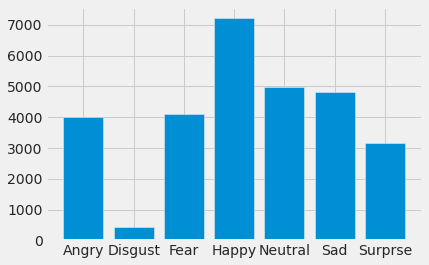

In [100]:
data = [Angry, Disgust, Fear, Happy, Neutral,Sad,Surprise]
plt.bar([1,2,3,4,5,6,7], data)
plt.xticks((1, 2,3,4,5,6, 7), ('Angry', 'Disgust', 'Fear','Happy', 'Neutral','Sad','Surprse'))
plt.show()

In [97]:
def show_images(dl):
    for images, labels in dl:
        fig, ax =plt.subplots(figsize=(15,15))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break

torch.Size([1, 48, 48])


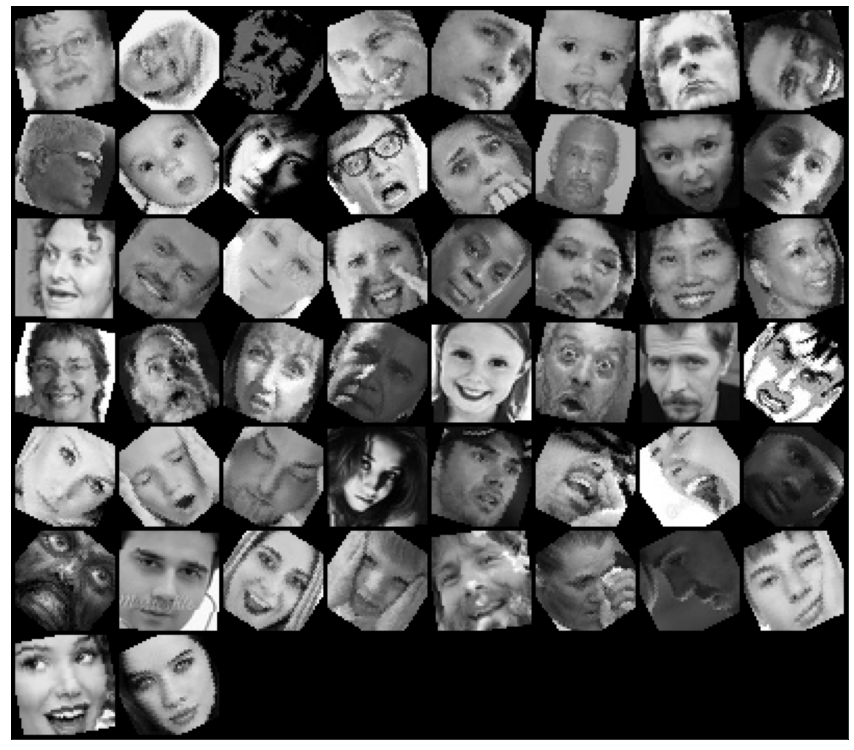

In [43]:
show_images(train_dl)



In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

 

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device) # add this line
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [14]:
model = to_device(ResNet(1,len(train_class)),device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    model.to(device)
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr ,model, train_loader, val_loader
                  ,weight_decay=0.0, grad_clip=None, 
                  opt_func = torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr ,weight_decay = weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))    
    for epoch in range(epochs):
        model.train()
        train_loss=[]
        lrs = []
        
        for batch in train_loader:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch , result)
        history.append(result)
    
    return history
    

In [16]:
history = [evaluate(model,valid_dl)]
history

[{'val_loss': 1.9507005214691162, 'val_acc': 0.015277777798473835}]

In [17]:
epochs =24
max_lr=0.008
grad_clip =0.1
weight_decay= 1e-4
opt_func = torch.optim.Adam


In [18]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00068, train_loss: 1.9211, val_loss: 1.6934, val_acc: 0.3537
Epoch [1], last_lr: 0.00169, train_loss: 1.8209, val_loss: 1.6884, val_acc: 0.3266
Epoch [2], last_lr: 0.00316, train_loss: 1.8649, val_loss: 1.7027, val_acc: 0.3290
Epoch [3], last_lr: 0.00483, train_loss: 1.7459, val_loss: 1.6077, val_acc: 0.3609
Epoch [4], last_lr: 0.00636, train_loss: 1.5759, val_loss: 1.5881, val_acc: 0.3788
Epoch [5], last_lr: 0.00749, train_loss: 1.5052, val_loss: 1.5125, val_acc: 0.3981
Epoch [6], last_lr: 0.00799, train_loss: 1.4862, val_loss: 1.6842, val_acc: 0.3325
Epoch [7], last_lr: 0.00796, train_loss: 1.4888, val_loss: 1.5896, val_acc: 0.4186
Epoch [8], last_lr: 0.00778, train_loss: 1.4864, val_loss: 1.8408, val_acc: 0.2845
Epoch [9], last_lr: 0.00746, train_loss: 1.4786, val_loss: 2.0724, val_acc: 0.2899
Epoch [10], last_lr: 0.00703, train_loss: 1.4637, val_loss: 2.6010, val_acc: 0.1510
Epoch [11], last_lr: 0.00649, train_loss: 1.4373, val_loss: 2.9922, val_acc: 0.1043
Ep

In [19]:
def plot_accuracy(history):
    acc = [x['val_acc'] for x in history]
    plt.plot(acc,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs Number of epochs')

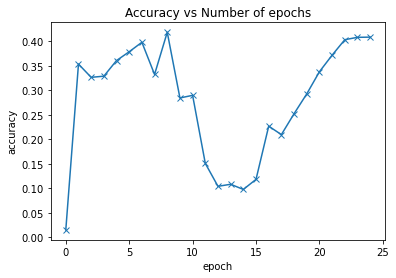

In [20]:
plot_accuracy(history)

In [23]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch No.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs Batch no.')

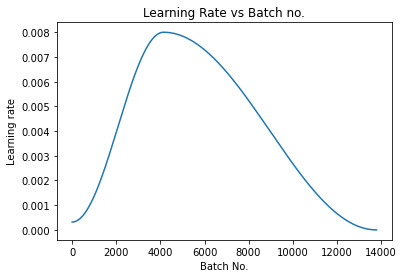

In [24]:
plot_lrs(history)

In [25]:
torch.save(model.state_dict(), 'Emotion_Detection.pth')